In [1]:
%load_ext autoreload
%autoreload 2

# Task 3: Eigenfaces & Fischerfaces (3 pts)

### <div align="right"> &copy; Markiian Novosad & Rostyslav Hryniv, 2023 </div>

## Completed by:   
*   First team member
*   Second team member


In this task your main goal is to discuss dimensionality reduction techniques, such as **PCA** and **LDA** and their performance on classification tasks.

A good source to read more on these methods is the book

*   Kevin P. Murphy. [Probabilistic Machine Learning: An Introduction](https://probml.github.io/pml-book/book1.html), MIT, 2022. Section 9.2.6 (FLDA), 20.1 (PCA and Eigenfaces)



## 1. Lib and Data prep (0.5 pts)
#### Let's start with importing all neccesary libraries and preparing our data

In [2]:
from PIL import Image
from sklearn.datasets import fetch_lfw_people
import numpy as np
from sklearn.svm import SVC
import sklearn
from matplotlib import pyplot as plt
import scipy
import random

Seed libs, so we get the same results every time:

In [3]:
sklearn.random.seed(1408)
np.random.seed(1408)

Fetch data and split them into training and test sets:

In [4]:
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.3)
n,h,w = lfw_people.images.shape
labels = lfw_people.target

class1, class2 =  1, 4 # choose your preferred classes, make sure that there is almost equal number of samples for each class

x= lfw_people.data[(labels == class1)|(labels==class2)]
y = labels[(labels == class2)|(labels==class1)]

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.33) # split data using sklearn library
x_train.shape, x_test.shape

((177, 1036), (88, 1036))

Visualise Your data:

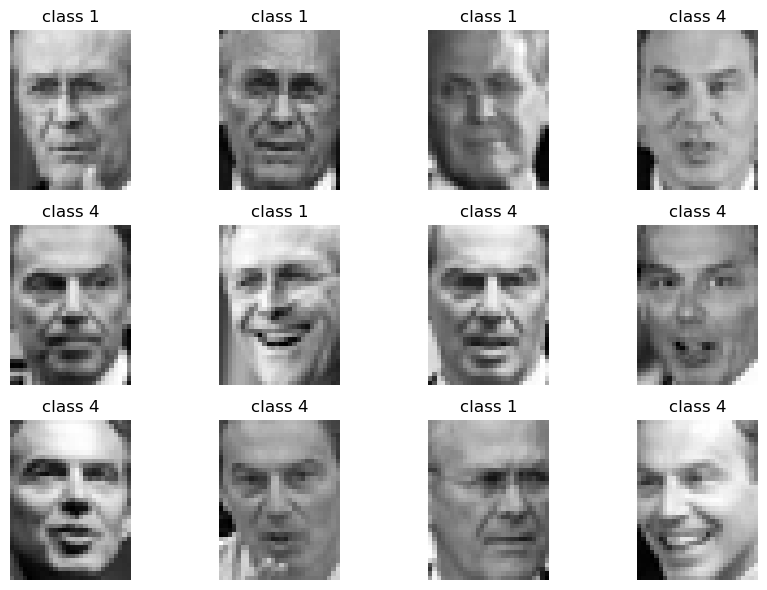

In [5]:
nrows = 3 
ncols = 4 
rc = nrows * ncols

idx = random.sample(range(x_train.shape[0]), rc)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*2.25, nrows*2))

for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        img = x_train[idx[i*ncols+j]].reshape((h, w))
        label = y_train[idx[i*ncols+j]]
        axes[i][j].imshow(img, cmap='grey')
        axes[i][j].set_title(f"class {label}")
        axes[i][j].axis('off')

plt.tight_layout()
plt.show()


In [130]:
x_train.shape

(177, 1036)

## 2. PCA (1.5 pts)


### **2.1 (0.7 pt) Implementation**
Let's start implementing the **PCA** algorithm

In [95]:
class MYPCA:
    def __init__(self) -> None:
        pass

    def _get_num_components(self, lambdas, threshold ) -> int:
        """
        Calculate minimal number of principal components so that variance explainability >= threshold.
        """
         # ========= YOUR CODE STARTS HERE ========= #
        lambdas = np.flip(np.sort(lambdas)) 

        lambdas_cum = np.cumsum(lambdas)
        lambdas_sum = lambdas_cum[-1]

        min_value = np.argmax(lambdas_cum / lambdas_sum >= threshold)
        
        return min_value

    def center_data(self, data):
        """
        Center our data by subtracting the mean
        """
         # ========= YOUR CODE STARTS HERE ========= #
        self._data_mean = np.mean(data, axis=0)
        return data - self._data_mean 
         # ========== YOUR CODE ENDS HERE ========== #


    def compute_eigen(self, cov_mat):
        """
        Using built-in numpy functionality, compute eigenvectors and eigenvalues of covariance matrix;
        """
        # ========= YOUR CODE STARTS HERE ========= #
        eigenvalues, eigenvectors = np.linalg.eig(cov_mat)
        # ========== YOUR CODE ENDS HERE ========== #

        return eigenvalues, eigenvectors


    def fit(self, data, exp_threshold=0.8):
        """
        1. Center the data;
        2. Compute covariance matrix
        3. Compute optimal k (number of components)
        4. Compute top-k eigenvalues from covariance matrix
        5. Compute components by projecting data with eigenvectors
        """
        # ========= YOUR CODE STARTS HERE ========= #

        data_norm = self.center_data(data)

        N = data_norm.shape[0]
        cov_mat = np.dot(data_norm.T, data_norm) / N

        self.eigenvalues, self.eigenvectors = self.compute_eigen(cov_mat=cov_mat)
        self._k_components = self._get_num_components(self.eigenvalues, exp_threshold)

        evs_desc_indices = np.argsort(self.eigenvalues)[::-1]

        top_k_vectors = (self.eigenvectors[evs_desc_indices])[:, :self._k_components]

        self.components =  data_norm.dot(top_k_vectors) # top_k_vectors.dot(data_norm)
        return self.components
        # ========== YOUR CODE ENDS HERE ========== #


    def plot_eigenvectors(self, im_shape):
        scale=2
        nrows, ncols = 3, 7 
        fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*scale, nrows*scale))
        for i, axs in enumerate(axes):
            for j, ax in enumerate(axs):
                component_image = self.eigenvectors[:, i*ncols+j].reshape(im_shape)
                ax.imshow(component_image, cmap='gray')
                ax.set_title(f'Eigenvector {i*ncols+j+1}')
                ax.axis('off')
        plt.show()

    def plot_components(self, im_shape):
        """
        For better understanding, visualise the *self.components* variable.
        """
        scale=2
        nrows, ncols = 3, 7 
        fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*scale, nrows*scale))

        inv_transformed = self.components.dot(self.eigenvectors[:, :self._k_components].T) + self._data_mean

        for i, ax_row in enumerate(axes):
            for j, ax in enumerate(ax_row):
                image = inv_transformed[i*ncols+j, :].reshape(im_shape)
                ax.imshow(image, cmap='gray')
                ax.set_title(f'Component {i*ncols+j+1}')
                ax.axis('off')
        plt.show()

    def plot_explainability(self):
        """
        Plot dependence of variance explainability on number of components.
        """
        # ========= YOUR CODE STARTS HERE ========= #
        exp_variance = np.cumsum(self.eigenvalues) / np.sum(self.eigenvalues)
        plt.plot(exp_variance)
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.show()
        # ========== YOUR CODE ENDS HERE ========== #

    def transform(self, data):
        """
        1. Center the data;
        2. Projection onto the components
        """
        # ========= YOUR CODE STARTS HERE ========= #
        data_norm = self.center_data(data)
        return data_norm.dot(self.eigenvectors[:, :self._k_components])
        # ========== YOUR CODE ENDS HERE ========== #

### **2.2 PCA Classifier (0.4 pts)**
Having implemented the **MYPCA** class, let's plot how our components look like and our explainability plot

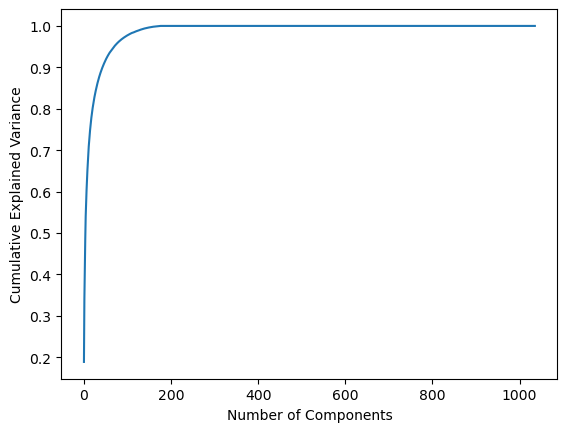

In [161]:
pca = MYPCA()
pca.fit(x_train, exp_threshold=0.8)
pca.plot_explainability()

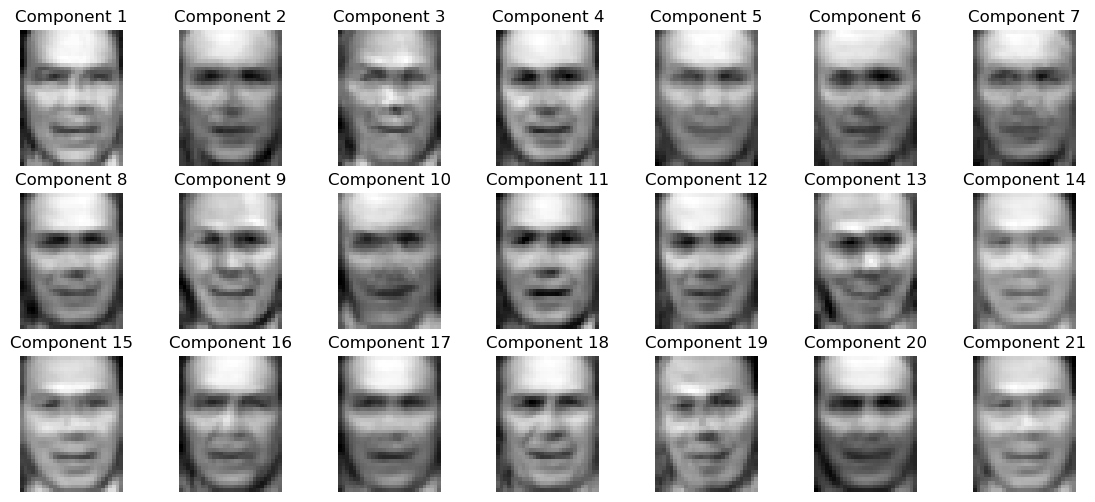

In [106]:
pca.plot_components(im_shape=(37, 28))

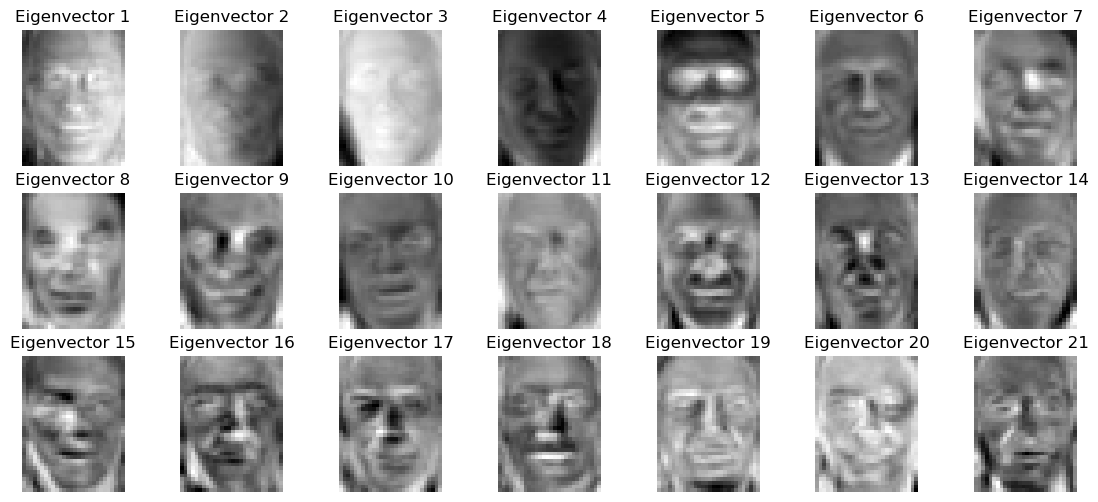

In [103]:
pca.plot_eigenvectors(im_shape=(37, 28))

Now, let's try to classify the data, using sklearn **SVC**.

In [162]:
classifier = SVC().fit(pca.transform(x_train), y_train)
print(classifier.score(pca.transform(x_test), y_test))

0.875


In [164]:
pca.components.shape

(177, 20)

### **2.3. Discussion of the results (0.4 pts):**
1. What is the concept of variance explainability and why is it so important?
1. What is the optimal number of components to reach good enough classification performance and why?

---

### **1.** 

Variance explainability is a ratio between a sum of a certain number of principal components (that is, eigenvalues of a matrix we are working with) and a sum of all components of a matrix. Formally, on the assumption that the eigenvalues are sorted in descending order, we can express variance explainability as

$$
\large{\dfrac{\sum\limits_{i=0}^{n-k} \lambda_i}{\sum\limits_{i=0}^{n} \lambda_i}}
$$ 

where $k$ is the number of components we choose to omit in our analysis and $n$ is the dimesionality of the matrix. The resulting number is the proportion of information that we keep in a marix with reduced dimensions. That is, the more principal components we omit, the less amount information is preserved, and if we don't omit any components, $varexp = 1$.

In PCA, this parameter is of a great importance since it allows us to make an accurate decision on which number of principal components (and therefore, dimensions) to keep in our analysis. An "accurate" decision in this context is such that keeps a balance between the information we don't want to lose and the size of a matrix that contains this information. That is, we want to have as small matrix as possible, so that it is computationally cheaper to work with. But, at the same time, it should still contain a good deal of the information from the initial matrix. 

That's why it is very useful to plot variance explainability and see how small the number of components can be so that we keep the desired amount of information (explainability) from the preprocessed data.

### **2.**

In our case, by keeping only $20$ components from the initial $1036$ yields quite a good performance of the classifier with the score of $0.875$. 

But we can keep reducing the number of components even further and try how well the classifier performs on the transformed data. In fact, keeping as few as $8$ components still gets a reasonably good score of $0.83$! After that, performance begins to deteriorate more quickly and with each dimension reduced we lose much greater fracions of the score. 

On the other hand, increasing the number of components does not actually improve the result significantly. Thus, a $127$-component matrix results in the score of $0.87$ (and corresponds to $0.99$ variance explainability). 

So, the optimal number of components that we should keep in our matrix is about $8-20$. With these numbers, we can expect the classifier score to range from $0.82$ to $0.88$


---

## 3. Fischerface classification and LDA (1 pt)
Now, having implemented the **PCA** algorithm, let's implement the **Linear Discriminant Analysis** algorithm.

By this [link](https://towardsdatascience.com/fishers-linear-discriminant-intuitively-explained-52a1ba79e1bb) you can read more about this algorithm.

In this task we will see how we can improve our classification using **LDA**.

### **3.1. (0.6 pt) Implementation**
Here you only need to compute the $\mathbf{\it{S_B}}$ and $\mathbf{\it{S_W}}$ covariance matrices, discussed in the source above, and select appropriate eigenvectors

In [ ]:
class MYLDA:

    def fit(self, data, data_labels, k_components):
        n_feats = data.shape[-1]
        SW = np.zeros((n_feats, n_feats))
        SB = np.zeros((n_feats, n_feats))
        mu = data.mean(0)

        # ========= YOUR CODE STARTS HERE ========= #

        for channel in np.unique(data_labels):
            ...
        # ========== YOUR CODE ENDS HERE ========== #

        evals, evecs = scipy.linalg.eigh(SB, SW)
        self.proj = ... # sort eigenvectors by eigenvalues and selet top k eigenvectors

    def transform(self, data):
        return data @ self.proj


Here we will implement the class for the Fischerface algorithm, which basically uses an **LDA** on top of **PCA**, such that we will perform maximum dimensionality reduction for classification purposes:

In [ ]:
class FischerFaces:
    def __init__(self) -> None:
        """
        Initialize pca and lda
        """
        self.pca = ...
        self.lda = ...

    def fit(self, X,Y, threshold, lda_components):
        """
        Fit the fischerface algo:
        1. Fit PCA
        2. Reduce data dimensions with PCA
        3. Fit LDA
        """
        self.pca.fit(...)
        pca_trans = ...
        self.lda.fit( pca_trans,  Y , lda_components )

    def transform(self, X):
        """
        Transform the data by using fitted PCA and LDA
        """
        return ...

Now, let's try out our new classifier based on Fischerface algorithm.

*Hint*: select the number of LDA components equal to the number of classes

In [ ]:
f = FischerFaces()
f.compute(x_train, y_train, ..., ...)

classifier = SVC().fit(f.transform(x_train), y_train)
print(...)

0.7014925373134329


### **2.2 Discussion (0.4 pts)**
Evaluate the results of Fishcerface classifier (LDA). Discuss whether it performs better than the classic Eigenface algorithm (PCA), and if so, why

---
#### **Your explanations come here**
---